# Events Table Stratified

__Description__: 
A Stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data (or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max. potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for statified sampling; maximum return interval limit for the statified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *Temporal_Distributions* folder, containing [precipitation temporal distribution data](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html) broken down by quartile for the specified volume, region, and duration.

    - The *Temporal_Distribution_Data_Map.json* which contains metadata used to extract the temporal distribution data from its *.csv file.

    - The *Temporal_Quartile_Ranks.xlsx* which contains the percentage of precipitation events whose temporal distributions are represented by those in each quartile. [Source](https://www.nws.noaa.gov/oh/hdsc/currentpf.html). 

    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: A *.csv* file containing mean incremental excess rainfall curves and a *.json* file containing the metadata associated with the curves.


#### Import Libraries

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*

In [2]:
## Excess rainfall parameters:
CN  = 73       # Curve number
mu  = 0.2  #Intial abstraction ratio parameter
PMP = 20   #inches, Probable Maximum Precipitation for the selected duration 

Return_Intervals = np.array([ 2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000]) #Return Intervals evaluated
RI_upper_bound = 3700 #Upper Limit of recurrence interval evaluation, Suggest not changing this value

duration = 24   # Event duration in hour #Must be a duration in the input Precip_Table File

#Integration parameters
n_partition = 30 #Define number of partitions of max. potential retention distribution.
                 #This controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'DesPlaines'  # Project area name
Pluvial_Model = 'P01'  # Pluvial model name
BCN = '071200040403'            # Domain/boundary condition name

precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN) 

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_plots = True
display_print = False
np.set_printoptions(suppress=True)

##### Convert all paths to objects:

In [3]:
inputs_dir = pl.Path(inputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
datarepository_dir = pl.Path(datarepository_dir)
bin_dir = pl.Path(bin_dir)
outputs_dir = pl.Path(outputs_dir)

#### Global (project specific):

In [4]:
## Excess rainfall parameters:
lower_limit, upper_limit = 1, 3000 

## Filenames and paths:
Temporal_Distribution_Data_Map = 'Temporal_Distribution_Data_Map.json'
Temporal_Quartile_Ranks = 'Temporal_Quartile_Ranks.xlsx'
CN_Distribution = 'NEH630_Table_10_1.json'
temporal_dir = datarepository_dir/'Temporal_Distributions'

### Precipitation Values

,Expected Value,Lower (90%),Upper (90%)
Tr,,,
1,2.379714,2.117918,2.702459
2,2.891592,2.574480,3.286755
5,3.701163,3.283337,4.207439
10,4.377602,3.863020,4.969184
25,5.377439,4.696378,6.100418
50,6.235949,5.403653,7.084265
100,7.189133,6.155010,8.170133
200,8.249031,6.967184,9.403857
500,9.851490,8.155633,11.288959


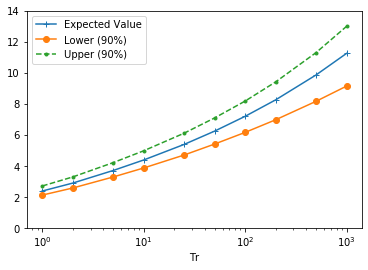

In [5]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)

raw_precip.plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, 14))

raw_precip

### Fit GEV to Rainfal Data (Find GEV parameters)

In [6]:
#Weights  of different NOAA Atlas value from the 1 to 1000 year event
weights = np.array([.5, .3, .1, .06, .02, .01, .005, .003, .001, .001])

#Average Value calculated from the NOAA data
Avg   = ( weights*raw_precip['Expected Value'].to_numpy() ).sum()
Avg_L = ( weights*raw_precip['Lower (90%)'].to_numpy() ).sum()
Avg_U = ( weights*raw_precip['Upper (90%)'].to_numpy() ).sum()

#Initial Value for the fit
GEV_parameters   = np.array([Avg*.8 , 0.5, -0.25])
GEV_parameters_L = np.array([Avg_L*.8 , 0.5, -0.25])
GEV_parameters_U = np.array([Avg_U*.8 , 0.5, -0.25])

#Bounds for GEV parameter values
bounds   = (( Avg*0.7, Avg*1.0), (.01, 1), (-0.5, 0))
bounds_L = (( Avg_L*0.7, Avg_L*1.0), (.01, 1), (-0.5, 0))  
bounds_U = (( Avg_U*0.7, Avg_U*1.0), (.01, 1), (-0.5, 0))  

df_GEV_parameters_E=Fit_GEV_Parameters(raw_precip, GEV_parameters, bounds, 'Expected Value', PMP)
GEV_parameters_E=df_GEV_parameters_E.to_numpy().transpose()[0]

df_GEV_parameters_L=Fit_GEV_Parameters(raw_precip, GEV_parameters_L, bounds_L, 'Lower (90%)', PMP)
GEV_parameters_L=df_GEV_parameters_L.to_numpy().transpose()[0]

df_GEV_parameters_U=Fit_GEV_Parameters(raw_precip, GEV_parameters_U, bounds_U, 'Upper (90%)', PMP)
GEV_parameters_U=df_GEV_parameters_U.to_numpy().transpose()[0]

dfs = [df_GEV_parameters_E, df_GEV_parameters_L, df_GEV_parameters_U]
df_GEV_parameters = pd.concat(dfs, axis=1)
df_GEV_parameters 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04256935345698326
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.056679706305320314
            Iterations: 13
            Function evaluations: 72
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.03237764600780822
            Iterations: 20
            Function evaluations: 110
            Gradient evaluations: 20


,GEV Expected Value,GEV Lower (90%),GEV Upper (90%)
mu,2.755150,2.446070,3.139806
sigma,0.574647,0.532820,0.627393
xi,-0.204410,-0.163136,-0.222337


### Plot Fitted GEV Distribution and NOAA Data

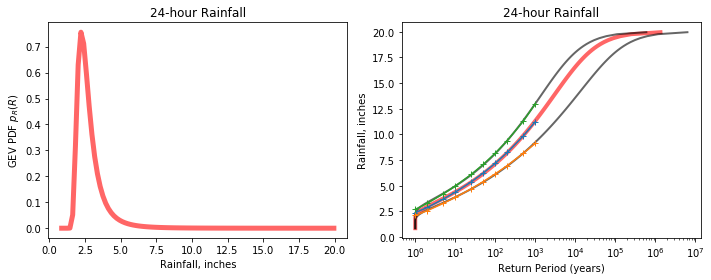

In [7]:
# Define figure including figure dimensions
fig, ((fig1a, fig1b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

#fig, ax = plt.subplots(1, 1)

Precip = np.linspace(PPF_GEV(10**-100, GEV_parameters, PMP),PPF_GEV(.999999, GEV_parameters, PMP), 100)

Return_Period_Precip_E=1/(1-CDF_GEV(Precip, GEV_parameters_E, PMP))
Return_Period_Precip_L=1/(1-CDF_GEV(Precip, GEV_parameters_L, PMP))
Return_Period_Precip_U=1/(1-CDF_GEV(Precip, GEV_parameters_U, PMP))

#Create First Panel Figure
fig1a.plot(Precip, PDF_GEV(Precip, GEV_parameters, PMP) ,
    'r-', lw=5, alpha=0.6, label='genextreme pdf')
fig1a.set_xlabel('Rainfall, inches'),fig1a.set_ylabel('GEV PDF $p_R(R)$'), fig1a.set_title('24-hour Rainfall')

#Create Second Panel Figure

fig1b.set_xscale('log')
fig1b.plot(Return_Period_Precip_E, Precip,
    'r-', lw=4, alpha=0.6, label='genextreme pdf')
fig1b.plot(Return_Period_Precip_L, Precip,
    'k-', lw=2, alpha=0.6, label='genextreme pdf')
fig1b.plot(Return_Period_Precip_U, Precip,
    'k-', lw=2, alpha=0.6, label='genextreme pdf')
raw_precip['Expected Value'].plot(style=['+-','o-','.--','s:'],logx=True)
raw_precip['Lower (90%)'].plot(style=['+-','o-','.--','s:'],logx=True )
raw_precip['Upper (90%)'].plot(style=['+-','o-','.--','s:'],logx=True)
fig1b.set_xlabel('Return Period (years)'),fig1b.set_ylabel('Rainfall, inches'), fig1b.set_title('24-hour Rainfall')

plt.tight_layout()
plt.show()

### Find Precipitation Value for Additional Events

In [8]:
#Non-exceedance probabilities of additional events considered
Non_Exceedance_Prob=1-1/Return_Intervals[Return_Intervals>1000]

#Create dataframe of additional RI and corresponding precipitation values
RI_additional = 1/(1-Non_Exceedance_Prob)  
Precip_additional_E = PPF_GEV(Non_Exceedance_Prob, GEV_parameters_E, PMP)
Precip_additional_L = PPF_GEV(Non_Exceedance_Prob, GEV_parameters_L, PMP)
Precip_additional_U = PPF_GEV(Non_Exceedance_Prob, GEV_parameters_U, PMP)

Precip_additional = np.vstack((Precip_additional_E, \
                               Precip_additional_L,Precip_additional_U)).T

df2=pd.DataFrame(data=Precip_additional, index= RI_additional.astype(int), \
                 columns=['Expected Value', 'Lower (90%)', 'Upper (90%)'])  # 

#Append value to existing dataframe
df_precip = raw_precip.append(df2)
df_precip

,Expected Value,Lower (90%),Upper (90%)
1,2.379714,2.117918,2.702459
2,2.891592,2.574480,3.286755
5,3.701163,3.283337,4.207439
10,4.377602,3.863020,4.969184
25,5.377439,4.696378,6.100418
50,6.235949,5.403653,7.084265
100,7.189133,6.155010,8.170133
200,8.249031,6.967184,9.403857
500,9.851490,8.155633,11.288959
1000,11.241816,9.135367,12.981429


### Find Precipitation Weights starting at a given return interval bin ceiling

In [9]:
#Length of Return Intervals array
Size = Return_Intervals.size

#Create array for bounds of bins for each eent
Bin_Bounds_R_topdown = np.zeros(Size+1)
#Populate the top bound for a topdown calculation of the event weights.
Bin_Bounds_R_topdown[Size] = RI_upper_bound

#Starting at the uppermost bin bound, the bin floors are calculated, consecutively.
for i in range(0, Size):
    Bin_Bounds_R_topdown[Size-i-1] = Bound_rainfall_L(Bin_Bounds_R_topdown[Size-i], \
                                                      Return_Intervals[Size-i-1], \
                                                      GEV_parameters_E, \
                                                      np.array([ Return_Intervals[Size-i-1]*.2 ]), \
                                                      PMP).x[0] 
    print('Bin Ceiling = %s, Bin Average = %s, Bin Floor = %s' \
          %(Bin_Bounds_R_topdown[Size-i], Return_Intervals[Size-i-1], Bin_Bounds_R_topdown[Size-i-1]))
    
#Calculate the event magnitude for the last event greater than the last return interval bin bound
#Define the maximum return interval input
Max_RI = RI_upper_bound

#Define avg. rainfall representative of an event between max return interval and the PMP
upper_bound = PMP 
lower_bound = PPF_GEV( 1-1/Max_RI, GEV_parameters_E, PMP)

#Calculate the Average/typical precipitation between the RI upper bound and PMP
Avg_PlusR = Avg_R(lower_bound, upper_bound, GEV_parameters_E, PMP)[0]/(1/Max_RI)
Prob_Plus =  CDF_GEV(Avg_PlusR, GEV_parameters_E, PMP)

#RI index for dataframe
RI_index = np.append(Return_Intervals, 1/(1-Prob_Plus)).astype(int) 
 
#weights of events   
weights_R_topdown = (1.0/Bin_Bounds_R_topdown[:-1]-1.0/Bin_Bounds_R_topdown[1:]).astype(float)
weights_R_topdown = np.append(weights_R_topdown,1/Max_RI)

weights_R_topdown_F = np.vstack(( Bin_Bounds_R_topdown, \
                                 np.append(Bin_Bounds_R_topdown[1:], np.inf), weights_R_topdown)).T
#dataframe of weights
df_weights =  pd.DataFrame(data=weights_R_topdown_F, index=RI_index, \
                           columns=['Bin Floor', 'Bin Celing','Event Weight']) 

#Extact NOAA rainfall values
R_NOAA_E = raw_precip.loc[2 : 3000]['Expected Value'].to_numpy()
df_R_NOAA_E = pd.DataFrame(raw_precip.loc[2 : 3000]['Expected Value'])

#Retreive the Non Exceedance probabilities of events not covered by NOAA Atlas 14
Non_Exceedance_Prob=1-1/Return_Intervals[Return_Intervals>1000]
Non_Exceedance_Prob = np.append(Non_Exceedance_Prob,Prob_Plus)

#For the additional RI events calculate the precipitation and return intervals
Precip_additional_E = PPF_GEV(Non_Exceedance_Prob, GEV_parameters_E, PMP)
RI_additional = np.append(Return_Intervals[Return_Intervals>1000], 1/(1-Prob_Plus) ) 

#Combine NOAA values and distribution based values
df2=pd.DataFrame(data=Precip_additional_E, index= RI_additional.astype(int), \
                 columns=['Expected Value'])  # 
df_precip = df_R_NOAA_E.append(df2)

#Final dataframe
df_weights_rainfall = pd.concat([df_weights,  df_precip], axis=1)
df_weights_rainfall

Bin Ceiling = 3700.0, Bin Average = 3000, Bin Floor = 2495.7395474709015
Bin Ceiling = 2495.7395474709015, Bin Average = 2000, Bin Floor = 1647.8371114991453
Bin Ceiling = 1647.8371114991453, Bin Average = 1000, Bin Floor = 683.7835089759388
Bin Ceiling = 683.7835089759388, Bin Average = 500, Bin Floor = 384.51956185074863
Bin Ceiling = 384.51956185074863, Bin Average = 200, Bin Floor = 125.36667250742693
Bin Ceiling = 125.36667250742693, Bin Average = 100, Bin Floor = 81.94454781562872
Bin Ceiling = 81.94454781562872, Bin Average = 50, Bin Floor = 34.18757604112893
Bin Ceiling = 34.18757604112893, Bin Average = 25, Bin Floor = 19.217092054950616
Bin Ceiling = 19.217092054950616, Bin Average = 10, Bin Floor = 6.281456665813109
Bin Ceiling = 6.281456665813109, Bin Average = 5, Bin Floor = 4.096316685512816
Bin Ceiling = 4.096316685512816, Bin Average = 2, Bin Floor = 1.261444049588403


,Bin Floor,Bin Celing,Event Weight,Expected Value
2,1.261444,4.096317,0.548621,2.891592
5,4.096317,6.281457,0.084923,3.701163
10,6.281457,19.217092,0.107162,4.377602
25,19.217092,34.187576,0.022787,5.377439
50,34.187576,81.944548,0.017047,6.235949
100,81.944548,125.366673,0.004227,7.189133
200,125.366673,384.519562,0.005376,8.249031
500,384.519562,683.783509,0.001138,9.851490
1000,683.783509,1647.837111,0.000856,11.241816
2000,1647.837111,2495.739547,0.000206,12.900703


### Retreive Max. Potential Retention Variability and Distribution Parameters

In [10]:
#NRCS value of wet and dry soil moiture conditions
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

#Table of wet, dry, and average (or median) soil moisture conditions
df_CN = prep_cn_table(CN, arc_data)  

#Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)

#Distribution parameter values
S_limit = 1000/fitted_cn.iloc[0]['CN Lower Limit']-10
alpha = fitted_cn.iloc[0]['alpha']
beta= fitted_cn.iloc[0]['beta']

fitted_cn

,AMC I (Dry),AMC II,AMC III (Wet),alpha,beta,CN Lower Limit,Fitted AMC I (Dry),Fitted AMC II,Fitted AMC III (Wet)
1,54,73,87,1.691003,2.60077,44.909981,54.000151,73.000117,86.999903


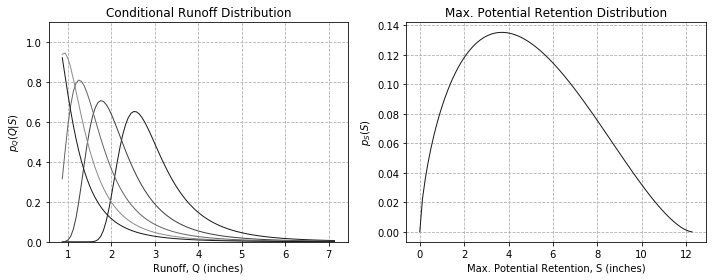

In [11]:
#Cycle though Color and line weights of graph
custom_cycler = cycler('color', ['.1', '.25', '.4', '.55']) + cycler('lw', [1, 1, 1, 1])

#Runoff x-axis values 
Q = np.linspace(PPF_GEV(10**-100, GEV_parameters_E, PMP), PPF_GEV(0.99, GEV_parameters_E, PMP), 100)

#Max. Potential Retention x-axis values
S = np.linspace(0, S_limit, 100)

fig, ((fig2a, fig2b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

#Plot Figure 2a
fig2a.set_prop_cycle(custom_cycler)
SA=np.linspace(.1, 3.5 , 5)
fig2a.plot(Q, np.transpose([PDF_QlS(Q, S1, mu, GEV_parameters_E, PMP) for S1 in SA]))
fig2a.grid(linestyle='--')
fig2a.set_ylim((0, 1.1))
fig2a.set_xlabel('Runoff, Q (inches)'),fig2a.set_ylabel('$p_Q(Q | S)$'), fig2a.set_title('Conditional Runoff Distribution')

#Plot Figure 2b
fig2b.set_prop_cycle(custom_cycler)
SA=np.linspace(.1, 3.5 , 5)
fig2b.plot(S, (1/S_limit)*stats.beta(alpha, beta).pdf(S/S_limit))
fig2b.grid(linestyle='--')
#fig2b.set_ylim((0, 1.1))
fig2b.set_xlabel('Max. Potential Retention, S (inches)'),fig2b.set_ylabel('$p_S(S)$'), fig2b.set_title('Max. Potential Retention Distribution')

plt.tight_layout()
plt.show()

### Partitions the max. potential distribution for calculating the runoff distribution

In [12]:
#Partition the Max. Potential Retention Distribution
#Define Probability for each partition
Delta_P=1/n_partition

#Define the bounds in probability space
Bounds  = np.linspace(0, 1,n_partition+1)

#Define the bounds in terms of the max. potential retention
Bounds_S = S_limit*stats.beta(alpha, beta).ppf(Bounds)

#Define the lower and upper bounds for each partition
Bounds_Lower = Bounds_S[:-1]
Bounds_Upper = Bounds_S[1:]

#Find the average value over each partition, which is the basis for the runoff distribution
partition_avg = np.transpose([S_avg_partition(alpha, beta, S_limit, lower, upper)[0] \
                              for lower, upper in zip(Bounds_Lower, Bounds_Upper)])/Delta_P
print(partition_avg )

#error between the integral approach (based on summation integration) and the actual value
error_PQ = 1- CDF_Q(PMP ,mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P)

#Print Results
print('\n'
      'Probability of zero runoff = %s \n' 
      'Error in calculation of Probabilibity of zero runoff = %s \n'
      'Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = %s'
      %(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP)[1], error_PQ ))

[ 0.46721141  0.96124733  1.32838278  1.64924009  1.94405423  2.2221562
  2.48886925  2.74763694  3.00089286  3.25048078  3.49788284  3.74435567
  3.99101879  4.23891713  4.48906994  4.74251339  5.00034219  5.26375528
  5.53411072  5.81299719  6.10233328  6.40451286  6.72263008  7.06084797
  7.42504473  7.82404899  8.27229238  8.79658066  9.45935888 10.55418328]

Probability of zero runoff = 0.0012449716778258435 
Error in calculation of Probabilibity of zero runoff = 1.7046333389561954e-09 
Error, i.e., the difference  between 1 and the numerical CDF evaluated at PMP,  Error = -0.0002616051728283608


## Runoff as a function of the return period

In [13]:
#Define Runoff as a function of RI based on cubic spline interpolation
n_partitions_Q= 40 #30 was too little, so increased to 40

#Determine
Q_line = np.linspace(.01, PMP-.1, n_partitions_Q+1)
Return_PeriodQ= 1/(1- np.transpose([error_PQ + CDF_Q( Q , mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P) for Q in Q_line]))

#Define Runoff as a function of the return interval with a cublic spline interpolation
tck_RI_Q = interpolate.splrep(Return_PeriodQ, Q_line)

#Define return interval as a function of the runoffl with a cublic spline interpolation
tck_Q_RI = interpolate.splrep( Q_line, Return_PeriodQ)

#Time the integration
#  %timeit CDF_Q( 3 , 0.2, alpha, beta, S_limit, GEV_parameters_E)

### Plot runoff distribution

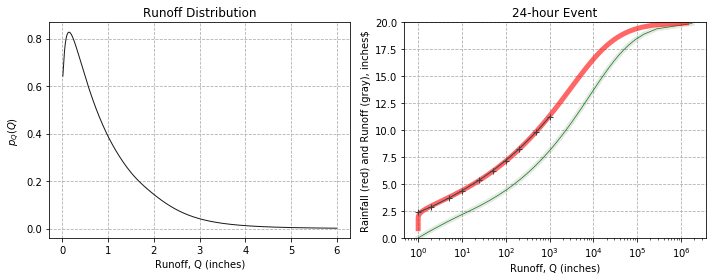

In [14]:
fig, ((fig3a, fig3b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

# x-axis value for the max. potential retention distribution
Q1= np.linspace(.01, 6, 1000)

#Plot Figure 3a
fig3a.set_prop_cycle(custom_cycler)
fig3a.plot(Q1,PDF_Q(Q1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P))
fig3a.grid(linestyle='--')
#fig2b.set_ylim((0, 1.1))
fig3a.set_xlabel('Runoff, Q (inches)'),fig3a.set_ylabel('$p_Q(Q)$'), fig3a.set_title('Runoff Distribution')

#Plot Figure 3b
fig3b.set_xscale('log')
fig3b.set_prop_cycle(custom_cycler)
#Return Inteval vs Runoff
fig3b.plot(Return_PeriodQ, Q_line, lw =5, alpha=.1)
#Plot Runoff vs Return interval based on the intepolation function
fig3b.plot(Return_PeriodQ, interpolate.splev(Return_PeriodQ, tck_RI_Q, der=0), 'g', lw =0.7)
#Return Interval vs Rainfall (i.e., Precipitation)
fig3b.plot(Return_Period_Precip_E, Precip,
    'r-', lw=5, alpha=0.6, label='genextreme pdf')
#NOAA Atlas 14 values
raw_precip['Expected Value'].plot(style=['+-','o-','.--','s:'],logx=True, ylim=(0, 18))
fig3b.grid(linestyle='--')
fig3b.set_ylim((0, PMP))
fig3b.set_xlabel('Runoff, Q (inches)'),fig3b.set_ylabel('Rainfall (red) and Runoff (gray), inches$'), fig3b.set_title('24-hour Event')

plt.tight_layout()
plt.show()

### Determine runoff values for given return intevals

In [15]:
#Define Representative runoff between the lower bound 3,000-year event and the PMP, which also is the maximum runoff amount

#Define the maximum return interval input
Max_RI = RI_upper_bound

#Define avg. runoff representative of an event between max return interval and the PMP
upper_bound = PMP 
lower_bound = interpolate.splev(Max_RI, tck_RI_Q, der=0)

#Calculate the Average/typical precipitation between the 3000-year event and PMP
Avg_Q_Upper = Avg_Q(lower_bound, upper_bound, mu, GEV_parameters_E, PMP, partition_avg, Delta_P)[0]/(1/Max_RI)
Non_Exceedance_Prob_Upper_Q = 1- (error_PQ + CDF_Q( Avg_Q_Upper, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P))

#Append event return interval to the list of return intervals
Return_Intervals_Q = np.append(Return_Intervals,1/Non_Exceedance_Prob_Upper_Q)
#Append event precipitation amount to the list of precipitation amounts
Runoff_Q = interpolate.splev(Return_Intervals_Q, tck_RI_Q, der=0)

#Dataframe of results
df_runoff = pd.DataFrame(data=Runoff_Q ,index=Return_Intervals_Q.astype(int), columns=['Runoff'])  # 
df_runoff

,Runoff
2,0.720946
5,1.574406
10,2.174618
25,2.967105
50,3.643213
100,4.425301
200,5.340703
500,6.794975
1000,8.105777
2000,9.610502


### Find runoff weights starting a given return interval bin ceiling

In [16]:
Size = Return_Intervals.size

Bin_Bounds = np.zeros(Size+1)

Bin_Bounds[Size] = RI_upper_bound

for i in range(0, Size):
    Bin_Bounds[Size-i-1] = Bound_L(Bin_Bounds[Size-i], Return_Intervals[Size-i-1], \
                                   mu, GEV_parameters_E, PMP, partition_avg,\
                                   Delta_P, np.array([1.0]), tck_RI_Q ).x[0] 
    print('Bin Ceiling = %s, Bin Floor %s' %( Bin_Bounds[Size-i],Bin_Bounds[Size-i-1] ) )

Bin Ceiling = 3700.0, Bin Floor 2492.406672176478
Bin Ceiling = 2492.406672176478, Bin Floor 1647.7473244806617
Bin Ceiling = 1647.7473244806617, Bin Floor 681.5085216898837
Bin Ceiling = 681.5085216898837, Bin Floor 385.1469431649283
Bin Ceiling = 385.1469431649283, Bin Floor 125.03393692035013
Bin Ceiling = 125.03393692035013, Bin Floor 82.15059991789758
Bin Ceiling = 82.15059991789758, Bin Floor 34.202880287188925
Bin Ceiling = 34.202880287188925, Bin Floor 19.51481625856721
Bin Ceiling = 19.51481625856721, Bin Floor 6.427958205041802
Bin Ceiling = 6.427958205041802, Bin Floor 3.8696206395505257
Bin Ceiling = 3.8696206395505257, Bin Floor 1.280372574874256


In [17]:
weights_runoff = (1.0/Bin_Bounds[:-1]-1.0/Bin_Bounds[1:]).astype(float)
weights_runoff = np.append(weights_runoff,1/Max_RI)
df_weights =  pd.DataFrame(data=weights_runoff  ,index=Return_Intervals_Q.astype(int), columns=['Event Weight']) 
df_weights_runoff = pd.concat([ df_weights,df_runoff ,], axis=1)
df_weights_runoff

,Event Weight,Runoff
2,0.522599,0.720946
5,0.102853,1.574406
10,0.104327,2.174618
25,0.022006,2.967105
50,0.017065,3.643213
100,0.004175,4.425301
200,0.005401,5.340703
500,0.001129,6.794975
1000,0.000860,8.105777
2000,0.000206,9.610502


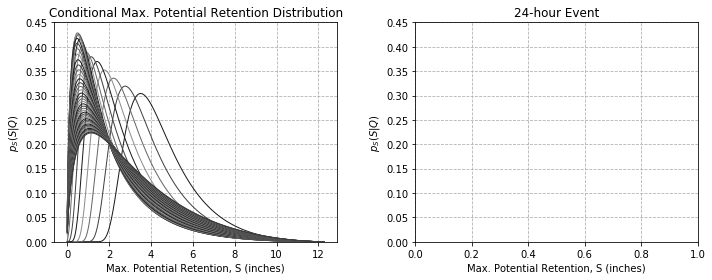

In [18]:
#Cycle though Color and line weights of graph
custom_cycler = cycler('color', ['.1', '.25', '.4', '.55']) + cycler('lw', [1, 1, 1, 1])

fig, ((fig4a, fig4b)) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))

S1= np.linspace(.01, S_limit, 1000)
S2= np.linspace(.01, S_limit, 10)

#Plot Figure 4a
fig4a.set_prop_cycle(custom_cycler)
QA=np.linspace(.5, 10 , 50)
fig4a.plot(S1, np.transpose([PDF_SlQ(S1, Q1, mu, GEV_parameters, PMP, partition_avg, Delta_P, alpha, beta, S_limit) for Q1 in QA]))
fig4a.grid(linestyle='--')
fig4a.set_ylim((0, .45))
fig4a.set_xlabel('Max. Potential Retention, S (inches)'),fig4a.set_ylabel('$p_S(S | Q)$'), fig4a.set_title('Conditional Max. Potential Retention Distribution')

#Plot Figure 4b
fig4b.set_prop_cycle(custom_cycler)
QA=np.linspace(2, 10 , 4)
#fig4b.plot(S2, np.transpose([CDF_SlQ(S2, Q1, mu, GEV_parameters, alpha, beta, S_limit) for Q1 in QA]))
fig4b.grid(linestyle='--')
fig4b.set_ylim((0, .45))
fig4b.set_xlabel('Max. Potential Retention, S (inches)'),fig4b.set_ylabel('$p_S(S | Q)$'), fig4b.set_title('24-hour Event')

plt.tight_layout()
plt.show()

### Calculate Runoff and Corresponding Max. Potential Retention and Rainfall

In [19]:
bounds= [(.25, S_limit)]

Initial_Value = np.array([1.5])

Avg_S_list = [Avg_SlQ(Q1, mu, GEV_parameters, PMP, partition_avg, Delta_P, alpha, beta, S_limit,0,S_limit)[0] for Q1 in Runoff_Q]

Median_S_list = [Median_S(Q1, mu, GEV_parameters, PMP, partition_avg, Delta_P, alpha, beta, S_limit, bounds, Initial_Value).x[0] for Q1 in Runoff_Q]

R_Avg_S = [1/2*(Q+np.sqrt(Q)*np.sqrt(Q+4*S)+2*S*mu) for Q, S in zip(Runoff_Q, Avg_S_list) ]

R_Median_S = [1/2*(Q+np.sqrt(Q)*np.sqrt(Q+4*S)+2*S*mu) for Q, S in zip(Runoff_Q, Median_S_list) ]

new_data = np.vstack(( Avg_S_list, R_Avg_S, Median_S_list, R_Median_S)).T

df_SR1 = pd.DataFrame(data=new_data, index=Return_Intervals_Q.astype(int), columns=['Avg. S', 'Rainfall','Median S', 'Rainfall'])

df_runoff_SR1 = pd.concat([df_weights_runoff, df_SR1], axis=1)
df_runoff_SR1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.164696981622586e-09
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1781657192465763e-08
            Iterations: 5
            Function evaluations: 15
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7586385613094752e-08
            Iterations: 4
            Function evaluations: 12
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.6033606907675694e-09
            Iterations: 4
            Function evaluations: 12
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.098868010529603e-07
            Iterations: 4
          

,Event Weight,Runoff,Avg. S,Rainfall,Median S,Rainfall
2,0.522599,0.720946,3.798466,2.813810,3.413961,2.652992
5,0.102853,1.574406,2.250843,3.277819,1.827745,3.022859
10,0.104327,2.174618,1.978923,3.825238,1.439217,3.451685
25,0.022006,2.967105,2.085311,4.796865,1.466610,4.336663
50,0.017065,3.643213,2.234442,5.653579,1.611396,5.175206
100,0.004175,4.425301,2.399240,6.631176,1.788761,6.149736
200,0.005401,5.340703,2.567903,7.749585,1.970977,7.266592
500,0.001129,6.794975,2.787247,9.476005,2.217577,8.999617
1000,0.000860,8.105777,2.946249,10.990961,2.395702,10.519092
2000,0.000206,9.610502,3.096438,12.694254,2.565276,12.228012


In [20]:
Avg_S_Lower50_list = [Avg_SlQ(Q1, mu, GEV_parameters, PMP, partition_avg, Delta_P, alpha,beta,S_limit,0,S1)[0]/0.5 for Q1, S1 in zip(Runoff_Q, Median_S_list)]
Avg_S_Upper50_list = [Avg_SlQ(Q1, mu, GEV_parameters, PMP, partition_avg, Delta_P, alpha,beta,S_limit,S1,S_limit)[0]/0.5 for Q1, S1 in zip(Runoff_Q, Median_S_list)]

R_Avg_S_Lower50 = [1/2*(Q+np.sqrt(Q)*np.sqrt(Q+4*S)+2*S*mu) for Q, S in zip(Runoff_Q, Avg_S_Lower50_list) ]
R_Avg_S_Upper50 = [1/2*(Q+np.sqrt(Q)*np.sqrt(Q+4*S)+2*S*mu) for Q, S in zip(Runoff_Q, Avg_S_Upper50_list) ]

new_data = np.vstack(( weights_runoff*.5, Avg_S_Lower50_list, R_Avg_S_Lower50, \
                      weights_runoff*.5, Avg_S_Upper50_list, R_Avg_S_Upper50)).T

df_SR2 = pd.DataFrame(data=new_data, index=Return_Intervals_Q.astype(int), columns=['Event Weight', 'Avg. S (Lower 50%)', 'Rainfall', 'Event Weight','Avg. S (Upper 50%)', 'Rainfall'])
df_runoff_SR2 = pd.concat([ df_runoff, df_SR2 ], axis=1)
df_runoff_SR2

,Runoff,Event Weight,Avg. S (Lower 50%),Rainfall,Event Weight,Avg. S (Upper 50%),Rainfall
2,0.720946,0.261300,2.562844,2.279318,0.261300,5.034087,3.306167
5,1.574406,0.051426,1.086385,2.530946,0.051426,3.415300,3.919090
10,2.174618,0.052164,0.744436,2.909846,0.052164,3.213410,4.588343
25,2.967105,0.011003,0.731976,3.721067,0.011003,3.438645,5.693177
50,3.643213,0.008532,0.804289,4.482154,0.008532,3.664594,6.637311
100,4.425301,0.002087,0.899567,5.371939,0.002087,3.898914,7.698779
200,5.340703,0.002701,0.999540,6.401410,0.002701,4.136267,8.903282
500,6.794975,0.000565,1.140497,8.017918,0.000565,4.433996,10.739658
1000,8.105777,0.000430,1.244047,9.450472,0.000430,4.648451,12.338203
2000,9.610502,0.000103,1.344355,11.074986,0.000103,4.848520,14.122838


---